In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from scipy.spatial.distance import cityblock, mahalanobis, euclidean


In [74]:
data = pd.read_csv("DSL-StrongPasswordData.csv")

In [75]:
# 51 total
subjects = data["subject"].unique()
# METRICHE: FAR (V),FRR (V),TAR (V),TRR (V),EER (V);ROC (V),Zero error rate,Zero FRR, Zero FAR, Detection error trade off

In [76]:
def evaluateEER_with_FAR_FRR(user_scores, imposter_scores):
    labels = [0] * len(user_scores) + [1] * len(imposter_scores)
    scores = user_scores + imposter_scores
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    missrates = 1 - tpr  # False Rejection Rate (FRR)
    farates = fpr        # False Acceptance Rate (FAR)
    
    # Find the Equal Error Rate (EER)
    dists = missrates - farates
    idx1 = np.argmin(dists[dists >= 0])
    idx2 = np.argmax(dists[dists < 0])
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]
    a = (x[0] - x[1]) / (y[1] - x[1] - y[0] + x[0])
    eer = x[0] + a * (y[0] - x[0])
    
    # Trova i valori di FAR e FRR al punto EER
    far_at_eer = farates[idx1]
    frr_at_eer = missrates[idx1]
    
    return eer, far_at_eer, frr_at_eer

def plot_figure(user_scores, imposter_scores):
    labels = [0] * len(user_scores) + [1] * len(imposter_scores)
    scores = user_scores + imposter_scores
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 1
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def compute_and_plot_FAR_FRR(user_scores, imposter_scores):

    labels = [0] * len(user_scores) + [1] * len(imposter_scores)
    scores = user_scores + imposter_scores
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    missrates = 1 - tpr  # False Rejection Rate (FRR)
    farates = fpr        # False Acceptance Rate (FAR)
    
    # Find the Equal Error Rate (EER)
    dists = missrates - farates
    idx1 = np.argmin(dists[dists >= 0])
    idx2 = np.argmax(dists[dists < 0])
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]
    a = (x[0] - x[1]) / (y[1] - x[1] - y[0] + x[0])
    eer = x[0] + a * (y[0] - x[0])
    threshold_at_eer = thresholds[idx1]
    
    # Calcolo di ZeroFAR e ZeroFRR corretti
    if 0 in farates:
        idx_zerofar = np.where(farates == 0)[0][0]
        threshold_zerofar = thresholds[idx_zerofar]
        zero_far_frr = missrates[idx_zerofar]  # FRR al punto di FAR=0
    else:
        threshold_zerofar, zero_far_frr = None, None

    if 0 in missrates:
        idx_zerofrr = np.where(missrates == 0)[0][0]
        threshold_zerofrr = thresholds[idx_zerofrr]
        zero_frr_far = farates[idx_zerofrr]  # FAR al punto di FRR=0
    else:
        threshold_zerofrr, zero_frr_far = None, None
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(thresholds, farates, label="FAR (False Acceptance Rate)", color="blue")
    plt.plot(thresholds, missrates, label="FRR (False Rejection Rate)", color="red")
    
    # Evidenziazione dei punti di interesse
    plt.scatter(threshold_at_eer, eer, color='purple', label=f"EER ({eer:.1f})", zorder=5)
    if threshold_zerofar is not None:
        plt.scatter(threshold_zerofar, zero_far_frr, color='green', label="ZeroFAR", zorder=5)
    if threshold_zerofrr is not None:
        plt.scatter(threshold_zerofrr, zero_frr_far, color='orange', label="ZeroFRR", zorder=5)
    
    # Personalizzazione del grafico
    plt.title("FAR vs FRR con punti EER, ZeroFAR e ZeroFRR")
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.ylim(0, 1)  # Partire esattamente da 0
    plt.legend()
    plt.grid()
    plt.show()
    
    return eer, threshold_at_eer, threshold_zerofar, threshold_zerofrr

    


In [77]:
class EuclideanDetector:
    
    def __init__(self, subjects):
        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = np.linalg.norm(self.test_genuine.iloc[i].values - self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = np.linalg.norm(self.test_imposter.iloc[i].values - self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []

        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)

        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

In [78]:
class EuclideanNormedDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = np.linalg.norm(self.test_genuine.iloc[i].values - self.mean_vector)**2
            cur_score = cur_score / np.linalg.norm(self.test_genuine.iloc[i].values)
            cur_score = cur_score / np.linalg.norm(self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = np.linalg.norm(self.test_imposter.iloc[i].values - self.mean_vector)**2
            cur_score = cur_score / np.linalg.norm(self.test_imposter.iloc[i].values)
            cur_score = cur_score / np.linalg.norm(self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)}      

In [79]:
class ManhattanDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

In [80]:
class ManhattanFilteredDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.std_vector = self.train.std().values
        dropping_indices = []
        for i in range(self.train.shape[0]):
            cur_score = euclidean(self.train.iloc[i].values, self.mean_vector)
            if (cur_score > 3*self.std_vector).all() == True:
                dropping_indices.append(i)
        self.train = self.train.drop(self.train.index[dropping_indices])
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

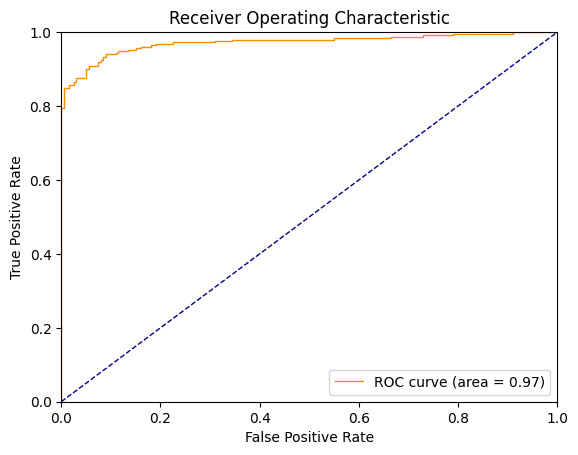

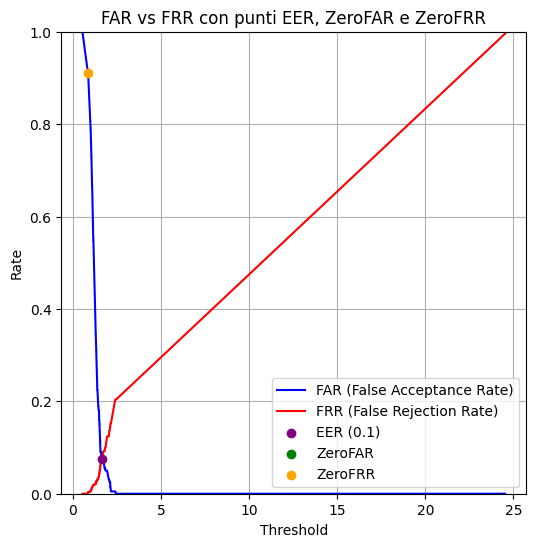

{'AVG EER': 0.12534927998872925,
 'STDEV EER': 0.08129721664813294,
 'FAR': 0.12441176470588236,
 'FRR': 0.13192156862745097,
 'TRR': 0.8755882352941177,
 'TAR': 0.868078431372549}

In [81]:
ManhattanFilteredDetector(subjects).evaluate()

In [82]:
class ManhattanScaledDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.mad_vector = self.train.sub(self.mean_vector, axis=1).abs().mean().values

        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = 0
            for j in range(len(self.mean_vector)):
                cur_score = cur_score + \
                            abs(self.test_genuine.iloc[i].values[j] - \
                                self.mean_vector[j]) / self.mad_vector[j]
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = 0
            for j in range(len(self.mean_vector)):
                cur_score = cur_score + \
                            abs(self.test_imposter.iloc[i].values[j] - \
                                self.mean_vector[j]) / self.mad_vector[j]
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

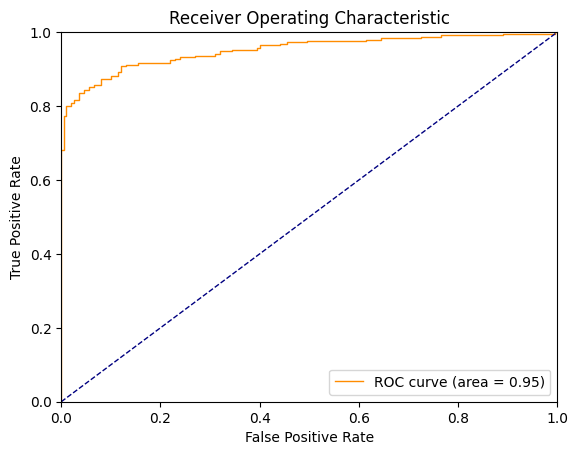

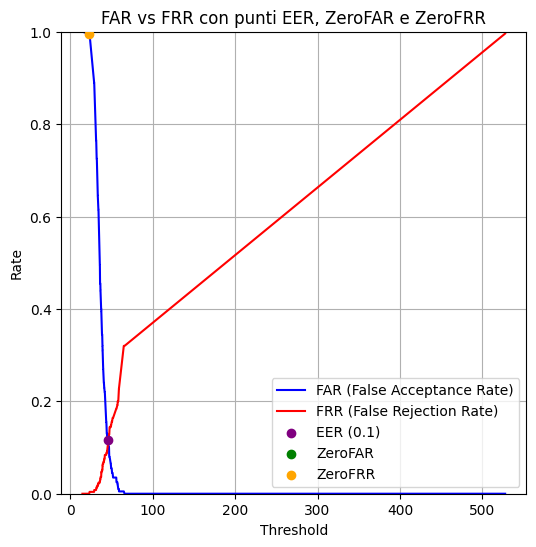

{'AVG EER': 0.09454084318639254,
 'STDEV EER': 0.0683741755687022,
 'FAR': 0.09372549019607844,
 'FRR': 0.10313725490196078,
 'TRR': 0.9062745098039215,
 'TAR': 0.8968627450980392}

In [83]:
ManhattanScaledDetector(subjects).evaluate() #MIGLIORATI con cambio di training

In [84]:
class MahalanobisDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.covinv = np.linalg.inv(np.cov(self.train.T))        
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            diff = self.test_genuine.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            diff = self.test_imposter.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

In [85]:
class MahalanobisNormedDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.covinv = np.linalg.inv(np.cov(self.train.T))        
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            diff = self.test_genuine.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            diff = self.test_imposter.iloc[i].values - self.mean_vector
            cur_score = np.dot(np.dot(diff.T, self.covinv), diff)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

In [86]:
class NearestNeighbourMahalanobisDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.covinv = np.linalg.inv(np.cov(self.train.T))        
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_scores = []
            for j in range(self.train.shape[0]):
                diff = self.test_genuine.iloc[i].values - self.train.iloc[j]
                cur_scores.append(np.dot(np.dot(diff.T, self.covinv), diff))
            self.user_scores.append(min(cur_scores))
            
        for i in range(self.test_imposter.shape[0]):
            cur_scores = []
            for j in range(self.train.shape[0]):
                diff = self.test_imposter.iloc[i].values - self.train.iloc[j]
                cur_scores.append(np.dot(np.dot(diff.T, self.covinv), diff))
            self.imposter_scores.append(min(cur_scores))
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

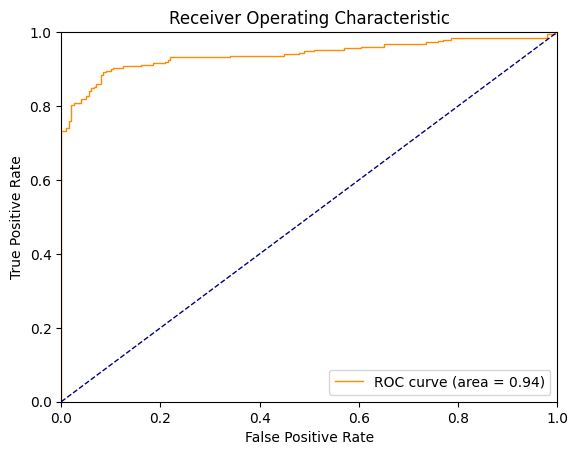

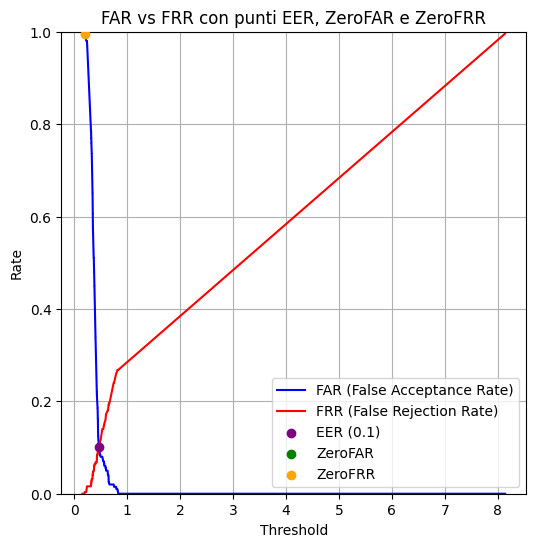

{'AVG EER': 0.16928649036431045,
 'STDEV EER': 0.09313837450860046,
 'FAR': 0.16784313725490196,
 'FRR': 0.17623529411764705,
 'TRR': 0.832156862745098,
 'TAR': 0.823764705882353}

In [87]:
EuclideanDetector(subjects).evaluate()

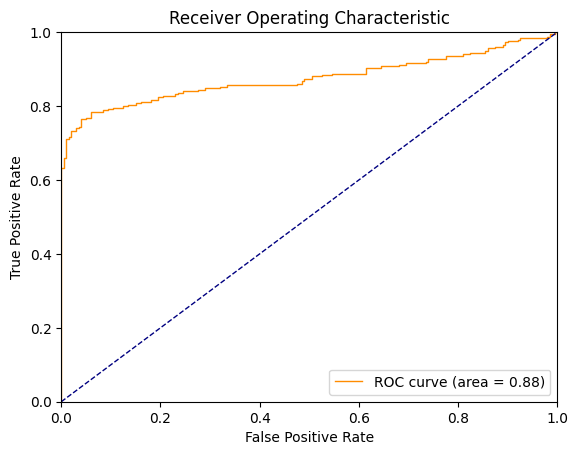

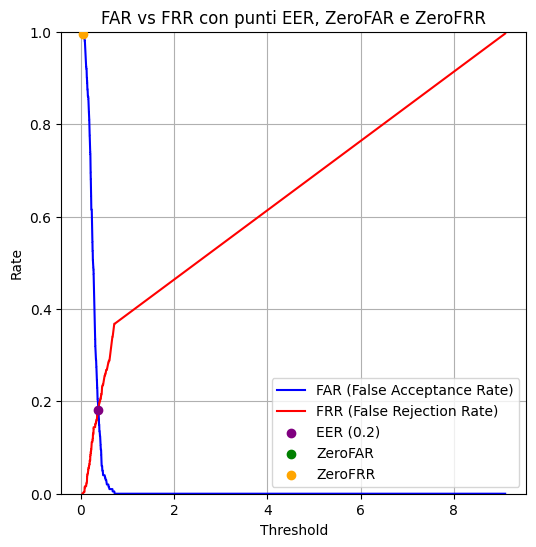

{'AVG EER': 0.21069715231915348,
 'STDEV EER': 0.11740261528927776,
 'FAR': 0.20872549019607842,
 'FRR': 0.21827450980392152,
 'TRR': 0.7912745098039216,
 'TAR': 0.7817254901960785}

In [88]:
EuclideanNormedDetector(subjects).evaluate()

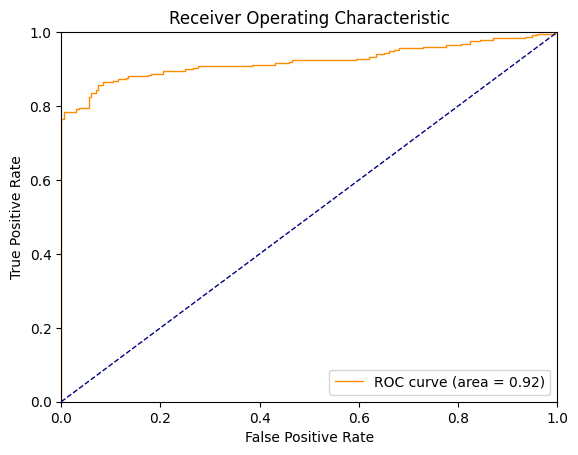

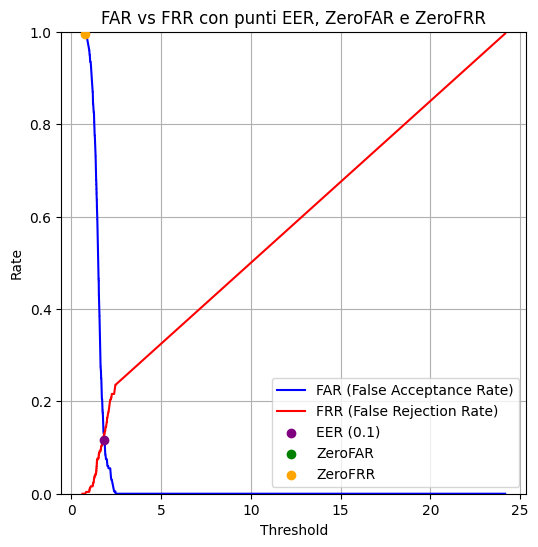

{'AVG EER': 0.15026997944690795,
 'STDEV EER': 0.09094241735620097,
 'FAR': 0.1493137254901961,
 'FRR': 0.15600000000000003,
 'TRR': 0.8506862745098039,
 'TAR': 0.844}

In [89]:
ManhattanDetector(subjects).evaluate()

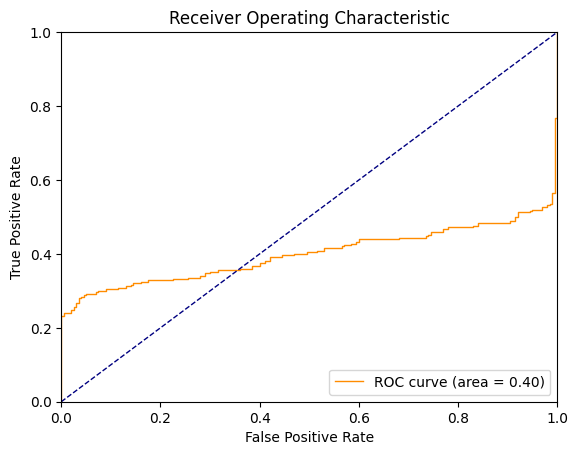

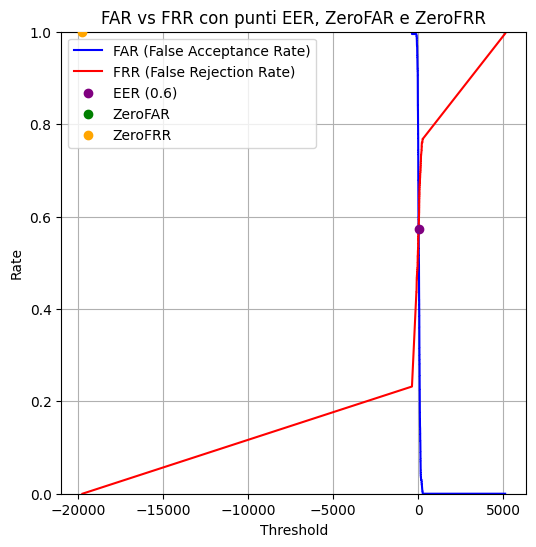

{'AVG EER': 0.24790454682491153,
 'STDEV EER': 0.13839594727575688,
 'FAR': 0.24519607843137256,
 'FRR': 0.25482352941176467,
 'TRR': 0.7548039215686274,
 'TAR': 0.7451764705882353}

In [90]:
MahalanobisDetector(subjects).evaluate()

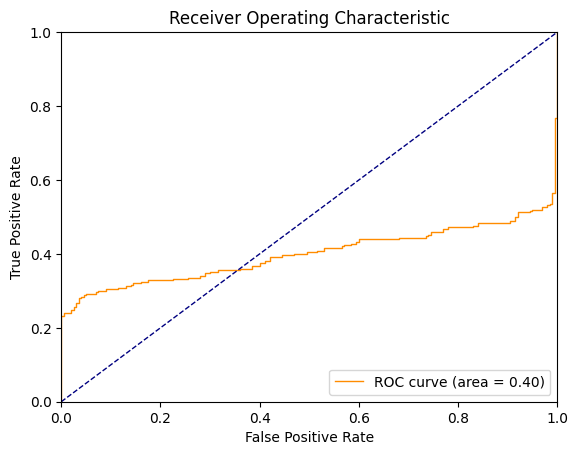

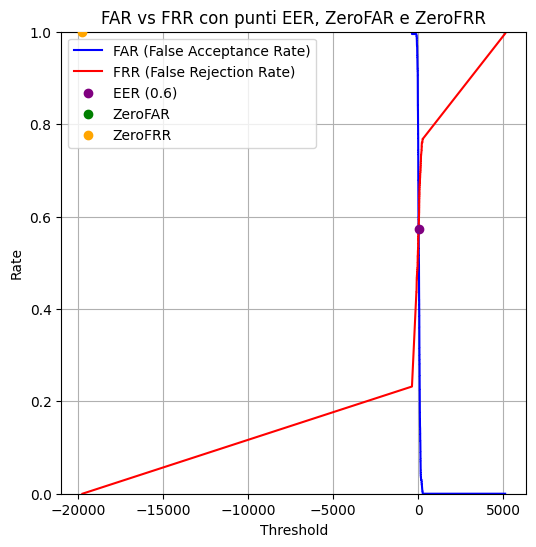

{'AVG EER': 0.24790454682491153,
 'STDEV EER': 0.13839594727575688,
 'FAR': 0.24519607843137256,
 'FRR': 0.25482352941176467,
 'TRR': 0.7548039215686274,
 'TAR': 0.7451764705882353}

In [91]:
MahalanobisNormedDetector(subjects).evaluate()

In [ ]:
NearestNeighbourMahalanobisDetector(subjects).evaluate() #lento o bug?

In [93]:
class OutlierCountingDetector:
    
    def __init__(self, subjects):

        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.std_vector = self.train.std().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cnt = 0.0
            for j in range(len(self.mean_vector)):
                cur_score = abs(self.test_genuine.iloc[i].values[j] - \
                                self.mean_vector[j]) // self.std_vector[j]
                if cur_score > 2.96:
                    cnt = cnt + 1.0
            self.user_scores.append(cnt)
            
        for i in range(self.test_imposter.shape[0]):
            cnt = 0.0
            for j in range(len(self.mean_vector)):
                cur_score = abs(self.test_imposter.iloc[i].values[j] - \
                                self.mean_vector[j]) // self.std_vector[j]
                if cur_score > 2.96:
                    cnt = cnt + 1.0     
            self.imposter_scores.append(cnt)
    
    def evaluate(self):
        eers = []
        fars = []
        frrs = []
        
        for subject in subjects:
            self.user_scores = []
            self.imposter_scores = []
    
            # Considera il soggetto corrente come genuino e gli altri come impostori
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # Dati di addestramento e test
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            self.testing()
    
            # Calcola EER, FAR, FRR
            eer, far, frr = evaluateEER_with_FAR_FRR(self.user_scores, self.imposter_scores)
            eers.append(eer)
            fars.append(far)
            frrs.append(frr)
        
        plot_figure(self.user_scores, self.imposter_scores)
        compute_and_plot_FAR_FRR(self.user_scores, self.imposter_scores)
        return { "AVG EER": np.mean(eers),"STDEV EER": np.std(eers),"FAR": np.mean(fars),"FRR": np.mean(frrs),"TRR": 1-np.mean(fars),"TAR": 1-np.mean(frrs)} 

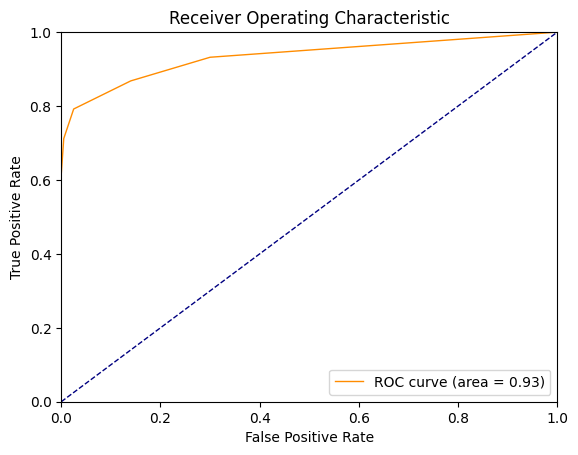

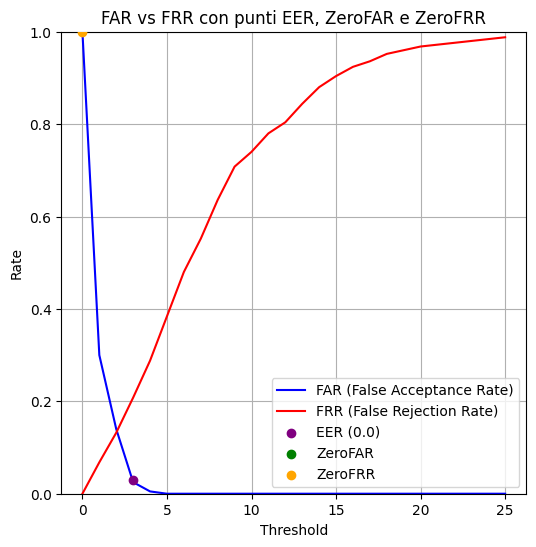

{'AVG EER': 0.10309683453558674,
 'STDEV EER': 0.07685487844204786,
 'FAR': 0.09186274509803921,
 'FRR': 0.19309803921568625,
 'TRR': 0.9081372549019608,
 'TAR': 0.8069019607843138}

In [94]:
OutlierCountingDetector(subjects).evaluate() #Good 